In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

This notebook shows how to construct the number of excess deaths (relative to a counterfactual 2020) from INSEE data on total deaths. It then compares these excess deaths to the counterfactual including Covid-19 deaths.

- The source for the INSEE data on total deaths is https://www.insee.fr/fr/information/4470857

- The source for the official Covid-19 deaths is https://dashboard.covid19.data.gouv.fr/

**ADDITIONAL CAVEAT** For the French data, we are only taking the average over the previous 2 years, rather than the previous 5 years, to calculate daily growth to extrapolate the 2020 series forward.

# 1) Processing the INSEE data

In [162]:
df = pd.read_csv('./total_deaths/total_deaths_france.csv')
df = df[~pd.isnull(df['2020'])].reset_index(drop=True).copy(deep=True)

computing the average of the cumulative totals across 2018-2019

In [163]:
df['cs_avg_1819'] = df.iloc[:,2:4].mean(axis=1)
df = df.drop(['{}'.format(yr) for yr in range(2018,2020)], axis=1)

computing daily growth rates 2018-2019

In [164]:
df['daily_growth'] = df.cs_avg_1819 / df.cs_avg_1819.shift(1)

extrapolating forward

In [165]:
df['counterfactual'] = 0
df.loc[0,'counterfactual'] = df.loc[df.date=='01-mars','2020'].values[0]

In [166]:
for i in range(1, df.shape[0]):
    df.loc[i,'counterfactual'] = df.loc[i-1,'counterfactual'] * df.loc[i,'daily_growth']

In [167]:
df = df.drop(['cs_avg_1819', 'daily_growth'], axis=1)

creating a date column

In [168]:
df.columns = ['aux', '2020', 'counterfactual_2020']
df['day'] = np.arange(1,24).astype('str')
df['day'] = ('0' + df['day']).str[-2:]
df['month'] = '03'
df['date'] = '2020-' + df.month + '-' + df.day
df['date']  =  pd.to_datetime(df['date'] , format='%Y%m%d', errors='ignore')
df = df[['date', '2020', 'counterfactual_2020']].reset_index(drop=True).copy(deep=True)

# 2) Processing the official covid data from Sante Publique France

In [169]:
official = pd.read_csv('./COVID_deaths/covid_deaths_france.csv')

In [170]:
official['date'] = pd.to_datetime(official['date'] , format='%&%m%d', errors='ignore')
official['covid_19'] = official.hopital + official.EHPD_EMS
official = official[['covid_19', 'date']]

# 3) Merging and plotting

In [171]:
df = pd.merge(df, official, on=['date'], how='left')
df = df.fillna(0)
df['counterfactual_2020_covid'] = df.counterfactual_2020 + df.covid_19
del df['covid_19']

In [172]:
df.index=df.date
del df['date']

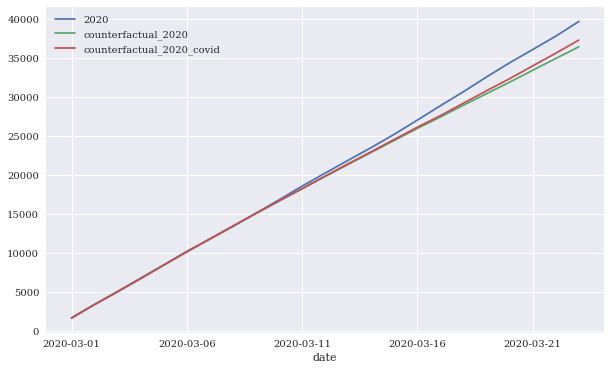

In [173]:
df.plot(figsize=(10,6))
plt.show()

In [174]:
print('Official covid-deaths: {} = red-green'.format(round(df.iloc[-1, 2] - df.iloc[-1, 1])))
print('Excess deaths: {} = blue-green'.format(round(df.iloc[-1, 0] - df.iloc[-1, 1])))
print('Unexplained excess deaths: {} = blue-red'.format(round(df.iloc[-1, 0] - df.iloc[-1, 2])))

Official covid-deaths: 860.0 = red-green
Excess deaths: 3249.0 = blue-green
Unexplained excess deaths: 2389.0 = blue-red
